<font size="10">Learning the Conjugacy Between the Tent and Logistic Maps</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a conjugacy between the tent, 
$x_{n+1} = 2\min\{x_n,1-x_n\}$, and logistic, $y_{n+1} = 4y_n(1-y_n)$, maps. The network simultaneously discovers an encoder, $\eta(x)$, and a decoder, $\rho(y)$, that approximate the conjugacy $h$ and its inverse $h^{-1}$.</font>

<font size="4">The exact conjugacy between these two mappings is given by 
$h(x) = \sin^2(\pi x/2)$ which we use the MATLAB script make_plots.m to plot our discovered encoder and decoder functions against $h$ and $h^{-1}$ to visually measure the performance of our trained network.</font> 

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.2 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

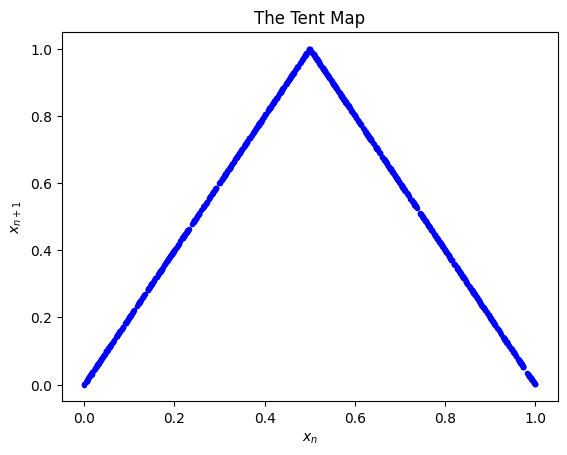

In [2]:
dtype = torch.float32

# Sample random points in the domain of the tent map [0,1]
N = 1000 # number of samples
xn = np.zeros((N,1))

for n in range(1,N):
    xn[n] = np.random.rand(1)
xnp1 = 2*np.minimum(xn, 1-xn) # forward iterate of the tent map

# Plot the tent map for visualization
plt.plot(xn,xnp1,'b.')
plt.xlabel('$x_n$',)
plt.ylabel('$x_{n+1}$')
plt.title('The Tent Map')
plt.rc('font', size= 16)

In [ ]:
# Conjugacy neural network architecture
class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = nn.SELU(),
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.numblksIn = numblksIn
        self.numblksOut = numblksOut
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        # Final layer to go to logistic map variables
        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function
        decoder_layers = [nn.Linear(self.size_y, self.width), self.activation]
        for _ in range(self.numblksOut-1):  # adding more layers
            decoder_layers.append(nn.Linear(self.width, self.width))
            decoder_layers.append(self.activation)

        # Final layer to go to tent map variables
        decoder_layers.append(nn.Linear(self.width, size_x))
        decoder_layers.append(self.activation)
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0, std=0.1)
            nn.init.normal_(module.bias, mean=0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x)
        encoded_p1 = 4*encoded - 4*torch.square(encoded) # logistic map step
        decoded = self.decoder(encoded_p1)

        # Encoder/Decoder loss
        x_recon = self.decoder(encoded)
        loss = torch.mean(torch.square(x - x_recon))

        # f = rho of g of eta loss
        xnp1 = 2*torch.minimum(x, 1-x)
        loss += torch.mean(torch.square(decoded - xnp1))

        # logistic map (g) loss
        xnp1_encoded = self.encoder(xnp1)
        loss += torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # logistic map (g) loss
        xnp1_encoded = self.encoder(xnp1)
        loss += torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # # L1L2 Regularization loss
        loss += sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        return decoded, loss

In [4]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 1 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = nn.SELU() # nonlinear activation function at each NN layer
learning_rate = 0.000005
numblks_in = 6 # number of layers for the encoder NN
numblks_out = 6 # number of layers for the decoder NN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out).to(device)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

xn = torch.tensor(xn, dtype=dtype).to(device)
train_dataloader = DataLoader(xn, batch_size=32)

In [5]:
def train(model, optimizer, train_dataloader, epochs=10, patience=200):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        min_loss = float('inf')
        for xt in train_dataloader:
            optimizer.zero_grad()
            decoded, loss = model(xt)

            loss.backward()
            optimizer.step()
            min_loss = min(min_loss, loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {min_loss}")

        if min_loss < best_loss:
            best_loss = min_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train(conjugacy, optimizer,train_dataloader, epochs=5000)

Epoch 1/5000, Loss: 17.292152404785156
Epoch 2/5000, Loss: 3.7194972038269043
Epoch 3/5000, Loss: 1.6859331130981445
Epoch 4/5000, Loss: 0.6355926990509033
Epoch 5/5000, Loss: 0.28369927406311035
Epoch 6/5000, Loss: 0.1577361524105072
Epoch 7/5000, Loss: 0.10950775444507599
Epoch 8/5000, Loss: 0.0915469080209732
Epoch 9/5000, Loss: 0.090264230966568
Epoch 10/5000, Loss: 0.09256129711866379
Epoch 11/5000, Loss: 0.08770628273487091
Epoch 12/5000, Loss: 0.07730704545974731
Epoch 13/5000, Loss: 0.0704134851694107
Epoch 14/5000, Loss: 0.06522691994905472
Epoch 15/5000, Loss: 0.06130245700478554
Epoch 16/5000, Loss: 0.05806833505630493
Epoch 17/5000, Loss: 0.05530461668968201
Epoch 18/5000, Loss: 0.0530422106385231
Epoch 19/5000, Loss: 0.05106217786669731
Epoch 20/5000, Loss: 0.04916606843471527
Epoch 21/5000, Loss: 0.04727214202284813
Epoch 22/5000, Loss: 0.04553605988621712
Epoch 23/5000, Loss: 0.043863940984010696
Epoch 24/5000, Loss: 0.042241379618644714
Epoch 25/5000, Loss: 0.0406723544

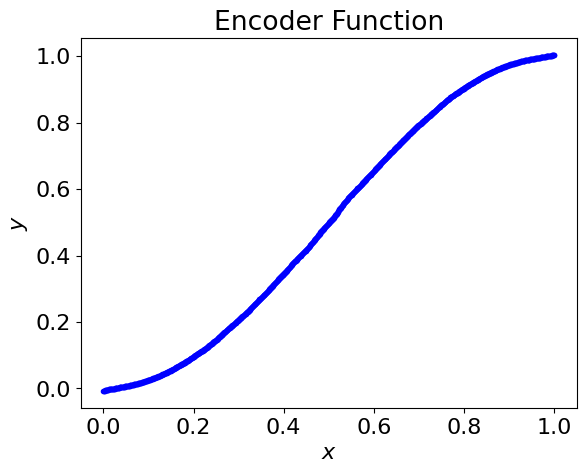

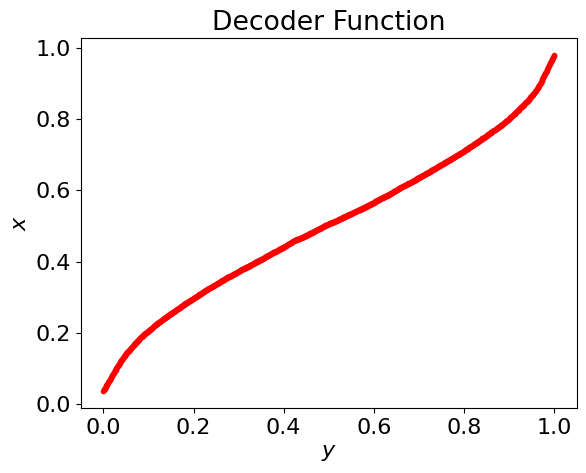

In [6]:
# View trained network

# Encoded variables
x = torch.tensor(np.linspace(0,1,N).reshape(-1,1), dtype=dtype).to(device)
y = conjugacy.encoder(x)

# Plot encoder/conjugacy function
fig = plt.figure()
plt.plot(x.cpu().detach(),y.cpu().detach(),'b.')
plt.xlabel('$x$',)
plt.ylabel('$y$')
plt.title('Encoder Function')
plt.rc('font', size= 16)

# Decoded variables
xdecode = conjugacy.decoder(x)

# Plot decoder/inverse conjugacy function
fig2 = plt.figure()
plt.plot(x.cpu().detach(),xdecode.cpu().detach(),'r.')
plt.xlabel('$y$',)
plt.ylabel('$x$')
plt.title('Decoder Function')
plt.rc('font', size= 16)

In [ ]:
# Loading and view the saved model
import tensorflow as tf

def loadModel(file_path, numblksIn=5, numblksOut=5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    tf_model = tf.keras.models.load_model(file_path, compile=False)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(numblksIn=numblksIn, numblksOut=numblksOut).to(device)
    for i in range(numblksIn+1):
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    for i in range(numblksOut+1):
        pytorch_model.decoder[2*i].weight = nn.Parameter(conju_wt[2*(i+numblksIn+1)].T)
        pytorch_model.decoder[2*i].bias = nn.Parameter(conju_wt[2*(i+numblksIn+1)+1])

    return pytorch_model

conjugacy = loadModel( "../saved_conjugacy_networks/Tent2Logistic")

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
